# Application of SVD: Latent Semantic Analysis

Strategy: given a corpus of articles, we want to create a term-document-type of matrix, for which we can do SVD analysis

In [3]:
import pickle
import os
import time

import numpy as np
import scipy.sparse.csr as csr
import scipy.sparse as sparse
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# I. Representing a corpus of documents as a matrix

## Bag of Words matrix

Following the <a href="http://scikit-learn.org/stable/modules/feature_extraction.html">Sklearn Feature-extraction documentation page</a>

- we start with a given **corpus** of $D$ documents.
- we preprocess each document and convert it into a list of terms (features)
    - by lowercasing first
    - accepting only word patterns (defined via regex)
- then we form the $CV$ Count-Vectorizer term-frequency matrix defined as:

$$
\text{tf}(t, d)\equiv{CF}_{d,t} = \text{# times term }t\text{ occurs in document }d
$$




In [4]:
from sklearn.feature_extraction.text import CountVectorizer

tpatterns = [
    '(?u)\\b\\w\\w+\\b', #default
    '(?u)\\b[a-zA-Z]\\w+\\b',
    '\\w',
    '\\w+',
    '(?u)\\b[a-zA-Z]\\w+\\b|\\b[0-9]\\b'
]

vectorizer = CountVectorizer(token_pattern=tpatterns[1])
vectorizer

CountVectorizer(token_pattern='(?u)\\b[a-zA-Z]\\w+\\b')

### If you are feeling rusty on your regular expressions, take a look at these examples:
https://www.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html

In [5]:
corpus = [
    'This is the the first first document abra.',
    'This is the second second document cadabra.',
    'And the third one 3.',
    'Is this the first document 4?',
]
X_corpus_docterm = vectorizer.fit_transform(corpus)
X_corpus_docterm

<4x11 sparse matrix of type '<class 'numpy.int64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [6]:
# note the effect of modifying the token_pattern above....
features = vectorizer.get_feature_names() 
features

/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abra',
 'and',
 'cadabra',
 'document',
 'first',
 'is',
 'one',
 'second',
 'the',
 'third',
 'this']

In [7]:
corpus = [
    'This is the the first first document abra.',
    'This is the second second document cadabra.',
    'And the third one 3.',
    'Is this the first document 4?',
]

In [8]:


for tp in tpatterns:
    vectorizer.token_pattern = tp
    print(vectorizer.token_pattern)
    X_corpus_docterm = vectorizer.fit_transform(corpus)
    features = vectorizer.get_feature_names()
    print(features)
    print('\n')


(?u)\b\w\w+\b
['abra', 'and', 'cadabra', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


(?u)\b[a-zA-Z]\w+\b
['abra', 'and', 'cadabra', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


\w
['3', '4', 'a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'm', 'n', 'o', 'r', 's', 't', 'u']


\w+
['3', '4', 'abra', 'and', 'cadabra', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


(?u)\b[a-zA-Z]\w+\b|\b[0-9]\b
['3', '4', 'abra', 'and', 'cadabra', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']




In [9]:
vectorizer.token_pattern = tpatterns[0] #back to the default
X_corpus_docterm = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names()
print(features)

['abra', 'and', 'cadabra', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


In [10]:
corpus

['This is the the first first document abra.',
 'This is the second second document cadabra.',
 'And the third one 3.',
 'Is this the first document 4?']

In [11]:
vectorizer.transform(['42', 'this this']).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]])

In [12]:
# This is our document-term matrix CV:
CV = X_corpus_docterm.toarray()
CV

array([[1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1],
       [0, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]])

## What if we want to vectorize a document in the test set?

E.g. this could even be a document with words not even encountered beforew

In [13]:
# just call the .transform() method of the trained vectorizer

def docs2vec(docs, vectorizer):
    return vectorizer.transform(docs)

docs_test = [
    'rain',
    'The a yoghurt',
    'three two one hurray',
    'and abra document is first cadabra',
    'one-third abra is the first cadabra and this document a second',
    
]

print(vectorizer.get_feature_names())

for doc in docs_test:
    print('\n')
    print(doc)
    print(docs2vec([doc], vectorizer).toarray())

X_docterm_test = docs2vec(docs_test, vectorizer)
print('\n')
print(X_docterm_test.toarray())

['abra', 'and', 'cadabra', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


rain
[[0 0 0 0 0 0 0 0 0 0 0]]


The a yoghurt
[[0 0 0 0 0 0 0 0 1 0 0]]


three two one hurray
[[0 0 0 0 0 0 1 0 0 0 0]]


and abra document is first cadabra
[[1 1 1 1 1 1 0 0 0 0 0]]


one-third abra is the first cadabra and this document a second
[[1 1 1 1 1 1 1 1 1 1 1]]


[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1]]


### Problems with Term-Document matrix:

- The document vectors are not normalized 
    - so can't really compare documents
    
- The document vectors contain many common english words containing no information
    - ideally we want to remove those, e.g. 'the', 'is', etc


### Solution: TF-IDF vectorizer (see <a href=http://scikit-learn.org/stable/modules/feature_extraction.html> The TF-idf section in the Scikit-Learn feature extraction manual</a>)

Instead, let's consider the following matrix

$$
\begin{align}
\text{tf-idf}(t,d) &\equiv{\text{tf}}(t,d)\times\text{idf}(t)\\
\text{idf}(t)&\equiv\log\frac{1+n_d}{1+\text{df}(d,t)} + 1
\end{align}
$$

where 

- $\text{df}(d,t)$ is the number of documents containing feature $t$
- the rows of the tf-idf matrix are normalized to have unit norm (either $L_1$ or $L_2$)
    - this way we can compare documents by the norm of their doc2vec overlaps
    
Let's see this in practice

In [29]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    norm='l2', # each output vector has l2 norm equal to 1
    use_idf=True)

# create a corpus with various levels of repetition of its terms
N = 1000
corpus = np.reshape(['blah', 'abra', 'cadabra'] * N, (N,3))
corpus[2:,2] = ''
corpus[int(N/2):,1] = ''
corpus = [' '.join(corpus[i]) for i in range(N)]

print('\n'.join(corpus[:30]))
#print('\n'.join(corpus[:]))

blah abra cadabra
blah abra cadabra
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 
blah abra 


In [30]:
X_corpus_tfidf=vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names()) 

# what happens to the weight of 'cadabra' when we vary N?
"""
As N goes down, weight goes down, this is because the occurance of cadabra 
in all documents remains unchanged=2, so the idf(d,t) doesn't change
however df(d,t) for 'blah' and 'abra' goes down, so their weight goes up

"""
# what happens to the weight of 'blah' and 'abra'?
""
# can you explain?
X_corpus_tfidf.toarray()[:10,:]

['abra', 'blah', 'cadabra']


array([[0.23873034, 0.14108119, 0.96078297],
       [0.23873034, 0.14108119, 0.96078297],
       [0.86090559, 0.50876474, 0.        ],
       [0.86090559, 0.50876474, 0.        ],
       [0.86090559, 0.50876474, 0.        ],
       [0.86090559, 0.50876474, 0.        ],
       [0.86090559, 0.50876474, 0.        ],
       [0.86090559, 0.50876474, 0.        ],
       [0.86090559, 0.50876474, 0.        ],
       [0.86090559, 0.50876474, 0.        ]])

# II. Latent Semantic Analysis

## Or Truncated SVD on the TF-IDF matrix

**The Following code is based on <a href="http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html">Scikit-Learn's Reuters Dataset TF-IDF + K-NN classification example</a> along with <a href="http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/">Chris McCormic's LSA tutorial</a> and his <a href="https://github.com/chrisjmccormick/LSA_Classification">github page</a>. The original Reuter's 21578 dataset is part of the <a href="http://archive.ics.uci.edu/ml/machine-learning-databases">UCI-ML</a> repository and can be found <a href="http://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/reuters21578.tar.gz">here</a>. However, in this demo we are using the already <a href="https://github.com/chrisjmccormick/LSA_Classification/tree/master/data">pre-processed</a> version in Chris McCormic's github page**


### Let's look at some real data - the Reuters Articles Corpus


In [31]:
fname = "raw_text_dataset.pickle"
filepath = os.getcwd() + '/' + fname
raw_text_dataset = pickle.load(open(filepath, "rb"))
corpus_train, labels_train = raw_text_dataset[0], raw_text_dataset[1] 
corpus_test, labels_test = raw_text_dataset[2], raw_text_dataset[3]

print('Number of train docs:', len(corpus_train), 'Number of test docs:', len(corpus_test))
print('\nExample train labels:', labels_train[:4])


Number of train docs: 4743 Number of test docs: 4858

Example train labels: [['cocoa', 'el-salvador', 'usa', 'uruguay'], ['usa'], ['usa'], ['usa', 'brazil']]


In [32]:
n = 4610
# n = 1238
# n = np.random.choice(len(corpus_train))

print('\nThis is how a article ', n,' looks like:\n\n', 
      corpus_train[n][:500])

print('\nAnd these are its topic labels:\n\n', 
      labels_train[n][:500])


This is how a article  4610  looks like:

 WESTINGHOUSE WX> TO DESIGN BRITISH NUCLEAR UNIT

Westinghouse Electric Corp said it will perform work valued in excess of 200 mln dlrs on the 1150-megawatt Sizewell B commercial nuclear power station which the United Kingdom will build near Suffolk on its southeast coast. Westinghouse said it will design and erect the primary reactor coolant system, manufacture components and transfer technology for the power plant which the U.K. government announced plans for yesterday. Westinghouse said its te

And these are its topic labels:

 ['usa', 'uk']


### TF-IDF vectorizer step:
The TfidfVectorizer below does the following:
- TF Step
    - Strips out “stop words”, e.g. frequently occuring english words
    - Filters out terms that occur in more than half of the docs
    (max_df=0.5)
    - Filters out terms that occur in only one document (min_df=2).
    - Selects the 10,000 most frequently occuring words in the corpus.
    - Normalizes the vector to account for the effect of document
    length on the tf-idf values. Here we use l1 norm which normalized
    by the document length
- IDF Step
    - Nomalize each 
    


In [33]:
vectorizer = TfidfVectorizer(
    max_df=0.5, # ignore terms which occur in more than half of the documents
    max_features=10000,
    min_df=2, # ignore terms which occur in less than 2 documents
    stop_words='english',
    norm='l2',
    use_idf=True, 
    analyzer='word',
#     token_pattern='(?u)\\b\\w\\w+\\b'
    token_pattern = '(?u)\\b[a-zA-Z]\\w+\\b'
    )

# note how changing the token_pattern changes the output below
X_train_tfidf = vectorizer.fit_transform(corpus_train)
print(X_train_tfidf.shape)
print('first 10 features:', vectorizer.get_feature_names()[:10])
print('last 10 features:', vectorizer.get_feature_names()[-10:])

(4743, 10000)
first 10 features: ['a300', 'a330', 'a340', 'aa', 'aaa', 'aapl', 'ab', 'abandon', 'abandoned', 'abandonment']
last 10 features: ['zinc', 'zntl', 'zoete', 'zone', 'zones', 'zorinsky', 'zortman', 'zuckerman', 'zurich', 'zy']


In [34]:
# let's look at documents that contain a target wordthe word '
# target_word = 'bullish'
target_word = 'cocoa'

doc_idx = X_train_tfidf[
    :, vectorizer.vocabulary_.get(target_word)].nonzero()[0].tolist()
print(len(doc_idx), ' documents found for target word: ', target_word)
i = np.random.choice(len(doc_idx))
print('document ', doc_idx[i], ':')
print(corpus_train[doc_idx[i]])

10  documents found for target word:  cocoa
document  3092 :
LCE AND IPE ELECT FIRST TRADED OPTIONS MEMBERS

The first 23 members have been elected to the joint traded options facility of the London Commodity Exchange (LCE) and the International Petroleum exchange (IPE), the exchanges said in a statement. More firms have applied and the final tranche will be admitted on April one and trading is planned to start in early June on the new trading floor on Commodity Quay. Traded options need a volatile and liquid futures base to succeed and chairman of the joint formation committee Jack Patterson said the existing LCE cocoa, coffee, sugar and IPE gas oil contracts should have no difficulty in providing this. Reuter 


In [35]:
X_train_tfidf

<4743x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 217725 stored elements in Compressed Sparse Row format>

In [50]:
print("\nPerforming dimensionality reduction using LSA")
t0 = time.time()

# Project the tfidf vectors onto the first N principal components.
# Though this is significantly fewer features than the original tfidf vector,
# they are stronger features, and the accuracy is higher.
svd = TruncatedSVD(
    n_components=200,
    random_state=42,
#     algorithm='arpack'
)

lsa = make_pipeline(
     
    Normalizer(copy=False), # try commenting this out. Do you get a better result?
    ## No, because it's already normalized
    svd,
)

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

print("  done in %.3fsec" % (time.time() - t0))


Performing dimensionality reduction using LSA
  done in 0.735sec


In [51]:
explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))


# Now apply the transformations to the test data as well.
# note that we are using the transform method only
X_test_tfidf = vectorizer.transform(corpus_test)
X_test_lsa = lsa.transform(X_test_tfidf)



  Explained variance of the SVD step: 39%


In [41]:
X_test_lsa.shape, X_test_tfidf.shape

((4858, 200), (4858, 10000))

### Let's improve a K-nn classifier using LSA

In [52]:
# The Reuters dataset consists of ~100 categories. However, we are going to
# simplify this to a binary classification problem. The 'positive class' will
# be the articles related to a given target label. All
# other articles will be negative.

target_label = 'acq'
# target_label = 'uk'
# target_label = 'japan'
# target_label = 'grain'
# target_label = 'earn'


y_train = [target_label in y for y in labels_train]
y_test = [target_label in y for y in labels_test]

print(np.array(y_train).sum(), 'articles found with target_label =', target_label)

590 articles found with target_label = acq


In [53]:
print("\nClassifying tfidf vectors...")

# Time this step.
t0 = time.time()

# Build a k-NN classifier. Use k = 5 (majority wins), the cosine distance, 
# and brute-force calculation of distances.
knn_tfidf = KNeighborsClassifier(
    n_neighbors=5, algorithm='brute', metric='cosine')
knn_tfidf.fit(X_train_tfidf, y_train)

# Classify the test vectors.
p_tfidf = knn_tfidf.predict(X_test_tfidf)

# Measure accuracy
numRight = 0;
for i in range(0,len(p_tfidf)):
    if p_tfidf[i] == y_test[i]:
        numRight += 1

print("  (%d / %d) correct - %.2f%%" % (numRight, len(y_test), float(numRight) / float(len(y_test)) * 100.0))

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)
print("  done in %.3fsec" % elapsed)


Classifying tfidf vectors...
  (4467 / 4858) correct - 91.95%
  done in 1.177sec


In [55]:
print("\nClassifying LSA vectors...")

# Time this step.
t0 = time.time()

# Build a k-NN classifier. Use k = 5 (majority wins), the cosine distance, 
# and brute-force calculation of distances.
knn_lsa = KNeighborsClassifier(
    n_neighbors=5, algorithm='brute', metric='cosine')
knn_lsa.fit(
    X_train_lsa, 
#     np.c_[X_train_lsa, X_train_tfidf.toarray()],
    y_train)

# Classify the test vectors.
p = knn_lsa.predict(
    X_test_lsa
#     np.c_[X_test_lsa, X_test_tfidf.toarray()],
)

# Measure accuracy
numRight = 0;
for i in range(0,len(p)):
    if p[i] == y_test[i]:
        numRight += 1

print("  (%d / %d) correct - %.2f%%" % (numRight, len(y_test), float(numRight) / float(len(y_test)) * 100.0))

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)    
print("    done in %.3fsec" % elapsed)



Classifying LSA vectors...
  (4556 / 4858) correct - 93.78%
    done in 0.633sec


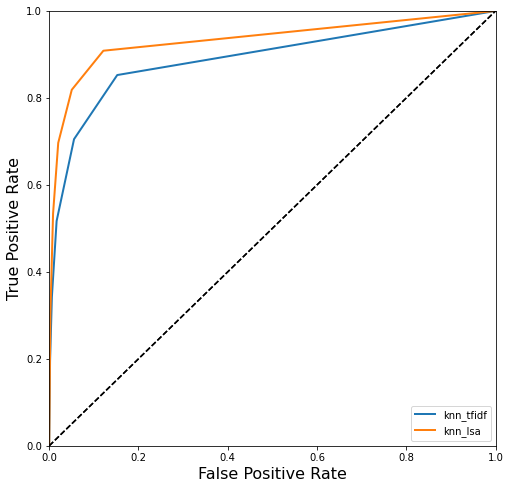

In [56]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


def plot_roc_curve(ax, fpr, tpr, label=None):
    ax.plot(fpr, tpr, linewidth=2, label=label)
    if label is not None:
        ax.legend()
    ax.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

models = {'knn_tfidf': knn_tfidf, 'knn_lsa': knn_lsa}
features_train = {'knn_tfidf': X_train_tfidf, 'knn_lsa': X_train_lsa}    

for i, mname in enumerate(models.keys()):
    # p_scores == y_predict
    p_scores = cross_val_predict(models[mname], features_train[mname], y_train, cv=10,
                             method="predict_proba")

    # hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
    # see https://github.com/scikit-learn/scikit-learn/issues/9589
    if p_scores.ndim == 2:
        p_scores = p_scores[:, 1]
    


    fpr, tpr, thresholds = roc_curve(y_train, p_scores)

    if i == 0:
        fig, ax = plt.subplots(1,1, figsize=(8,8))
    plot_roc_curve(ax, fpr, tpr, label=mname)

plt.show()

In [57]:
p_scores

array([0. , 0. , 0.2, ..., 0. , 0. , 0. ])